# AI-Powered Crop Yield Prediction - Model Training

This notebook demonstrates the complete pipeline for training crop yield prediction models using synthetic agricultural data.

## Overview
- Load and explore crop yield data
- Preprocess features (normalize per hectare, encode categoricals)
- Train multiple models (Random Forest, XGBoost)
- Evaluate performance and save best model
- Generate feature importance plots


In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import xgboost as xgb
import joblib
import shap
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

print("Libraries imported successfully!")


Libraries imported successfully!


## 1. Load and Explore Data


In [2]:
# Load the dataset
df = pd.read_csv('../data/processed/Final_Odisha_Crops.csv')

print("Dataset shape:", df.shape)
print("\nFirst 5 rows:")
df.head()


Dataset shape: (6233, 15)

First 5 rows:


,year,state,district,crop,season,soil_type,irrigation,seed_variety,area,rainfall,temperature,fertilizer,pesticide,production,yield
0,1997,Odisha,Sundargarh,Arhar/Tur,Autumn,Mixed Red & Yellow,Lift,Local,25621.0,1496.6,21.890000,2438350.57,7942.51,6487.0,0.202778
1,1997,Odisha,Sundargarh,Arhar/Tur,Summer,Mixed Red & Yellow,Lift,Local,86559.0,1496.6,25.690000,8237820.03,26833.29,16414.0,0.216786
2,1997,Odisha,Sundargarh,Arhar/Tur,Winter,Mixed Red & Yellow,Lift,Hybrid,116553.0,1496.6,19.876667,11092349.01,36131.43,23305.0,0.198929
3,1997,Odisha,Sundargarh,Groundnut,Autumn,Mixed Red & Yellow,Tubewell,Hybrid,37462.0,1496.6,21.890000,3565258.54,11613.22,34433.0,0.840435
4,1997,Odisha,Sundargarh,Groundnut,Summer,Lateritic,Lift,Local,39729.0,1496.6,25.690000,3781008.93,12315.99,48815.0,1.211071


In [3]:
# Basic dataset information
print("Dataset Info:")
df.info()

print("\nDataset Description:")
df.describe()


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6233 entries, 0 to 6232
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   year          6233 non-null   int64  
 1   state         6233 non-null   object 
 2   district      6233 non-null   object 
 3   crop          6233 non-null   object 
 4   season        6233 non-null   object 
 5   soil_type     6233 non-null   object 
 6   irrigation    5607 non-null   object 
 7   seed_variety  6233 non-null   object 
 8   area          6233 non-null   float64
 9   rainfall      6233 non-null   float64
 10  temperature   6233 non-null   float64
 11  fertilizer    6233 non-null   float64
 12  pesticide     6233 non-null   float64
 13  production    6233 non-null   float64
 14  yield         6233 non-null   float64
dtypes: float64(7), int64(1), object(7)
memory usage: 730.6+ KB

Dataset Description:


,year,area,rainfall,temperature,fertilizer,pesticide,production,yield
count,6233.000000,6.233000e+03,6233.000000,6233.000000,6.233000e+03,6.233000e+03,6.233000e+03,6233.000000
mean,2017.641906,2.000027e+04,668.228686,23.060521,4.725997e+06,9.743218e+03,4.473224e+04,9574.502222
std,5.003573,2.365176e+05,551.494605,0.922289,3.230913e+07,6.589797e+04,3.568780e+05,23434.618531
min,1997.000000,5.000000e-01,50.000000,19.876667,4.733500e+03,8.460000e+00,1.000000e+01,0.077333
25%,2016.000000,1.770000e+00,168.000000,22.945000,2.342137e+06,4.996150e+03,1.548250e+04,1247.000000
50%,2018.000000,3.070000e+00,286.000000,22.945000,2.342137e+06,4.996150e+03,1.548250e+04,2821.000000
75%,2021.000000,4.350000e+00,1214.000000,22.945000,2.342137e+06,4.996150e+03,1.548250e+04,4127.000000
max,2023.000000,8.629000e+06,1716.900000,28.860000,1.301253e+09,2.674990e+06,8.343100e+06,131596.000000


In [4]:
# Check for missing values
print("Missing values:")
print(df.isnull().sum())

# Check unique values in categorical columns
print("\nUnique values in categorical columns:")
categorical_cols = ['state', 'district', 'crop', 'season', 'soil_type', 'irrigation', 'seed_variety']
for col in categorical_cols:
    print(f"{col}: {df[col].unique()}")


Missing values:
year              0
state             0
district          0
crop              0
season            0
soil_type         0
irrigation      626
seed_variety      0
area              0
rainfall          0
temperature       0
fertilizer        0
pesticide         0
production        0
yield             0
dtype: int64

Unique values in categorical columns:
state: ['Odisha']
district: ['Sundargarh' 'Angul' 'Balangir' 'Balasore' 'Bargarh' 'Bhadrak' 'Boudh'
 'Cuttack' 'Deogarh' 'Dhenkanal' 'Gajapati' 'Ganjam' 'Jagatsinghpur'
 'Jajpur' 'Jharsuguda' 'Kalahandi' 'Kandhamal' 'Kendrapara' 'Keonjhar'
 'Khordha' 'Koraput' 'Malkangiri' 'Mayurbhanj' 'Nabarangpur' 'Nayagarh'
 'Nuapada' 'Puri' 'Rayagada' 'Sambalpur' 'Sonepur']
crop: ['Arhar/Tur' 'Groundnut' 'Horse-Gram' 'Jute' 'Maize' 'Potato' 'Ragi'
 'Sesamum' 'Sugarcane' 'Urad' 'Wheat' 'Moong(Green Gram)'
 'Rapeseed &Mustard' 'Rice' 'Bajra' 'Castor Seed' 'Coriander'
 'Cotton(Lint)' 'Dry Chillies' 'Garlic' 'Ginger' 'Gram' 'Jowar' 'Linseed'

## 2. Data Preprocessing


In [5]:
# Create a copy for preprocessing
df_processed = df.copy()

# Normalize fertilizer and pesticide to per hectare
df_processed['fertilizer_per_ha'] = df_processed['fertilizer'] / df_processed['area']
df_processed['pesticide_per_ha'] = df_processed['pesticide'] / df_processed['area']

print("Added normalized features:")
print(f"Fertilizer per ha - Mean: {df_processed['fertilizer_per_ha'].mean():.2f}, Std: {df_processed['fertilizer_per_ha'].std():.2f}")
print(f"Pesticide per ha - Mean: {df_processed['pesticide_per_ha'].mean():.2f}, Std: {df_processed['pesticide_per_ha'].std():.2f}")


Added normalized features:
Fertilizer per ha - Mean: 1055144.50, Std: 911310.31
Pesticide per ha - Mean: 2250.79, Std: 1943.97


In [6]:
# Define feature columns
numeric_features = ['area', 'rainfall', 'temperature', 'fertilizer_per_ha', 'pesticide_per_ha']
categorical_features = ['state', 'district', 'crop', 'season', 'soil_type', 'irrigation', 'seed_variety']

# Create feature matrix X and target y
X = df_processed[numeric_features + categorical_features]
y = df_processed['yield']

print(f"Feature matrix shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"Numeric features: {numeric_features}")
print(f"Categorical features: {categorical_features}")


Feature matrix shape: (6233, 12)
Target shape: (6233,)
Numeric features: ['area', 'rainfall', 'temperature', 'fertilizer_per_ha', 'pesticide_per_ha']
Categorical features: ['state', 'district', 'crop', 'season', 'soil_type', 'irrigation', 'seed_variety']


In [7]:
# Create preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_features)
    ]
)

print("Preprocessing pipeline created successfully!")


Preprocessing pipeline created successfully!


## 3. Model Training and Evaluation


In [8]:
# Split data using time-based split (use year for temporal split)
# Use 2020-2022 for training, 2023 for testing
train_mask = df_processed['year'] <= 2022
test_mask = df_processed['year'] > 2022

X_train, X_test = X[train_mask], X[test_mask]
y_train, y_test = y[train_mask], y[test_mask]

print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")


Training set: 5623 samples
Test set: 610 samples


In [9]:
# Create model pipelines
rf_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))
])

xgb_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', xgb.XGBRegressor(n_estimators=100, random_state=42, verbosity=0))
])

print("Model pipelines created!")


Model pipelines created!


In [10]:
# Train models
print("Training Random Forest...")
rf_pipeline.fit(X_train, y_train)

print("Training XGBoost...")
xgb_pipeline.fit(X_train, y_train)

print("Training completed!")


Training Random Forest...
Training XGBoost...
Training completed!


In [11]:
# Evaluate models
def evaluate_model(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    
    print(f"\n{model_name} Performance:")
    print(f"MAE: {mae:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"R²: {r2:.4f}")
    
    return {'mae': mae, 'rmse': rmse, 'r2': r2, 'predictions': y_pred}

# Evaluate both models
rf_results = evaluate_model(rf_pipeline, X_test, y_test, "Random Forest")
xgb_results = evaluate_model(xgb_pipeline, X_test, y_test, "XGBoost")



Random Forest Performance:
MAE: 1958.8303
RMSE: 6152.1414
R²: 0.9422

XGBoost Performance:
MAE: 2130.1155
RMSE: 6572.2468
R²: 0.9341


In [12]:
# Select best model based on R² score
if rf_results['r2'] > xgb_results['r2']:
    best_model = rf_pipeline
    best_model_name = "Random Forest"
    print(f"\nBest model: {best_model_name} (R² = {rf_results['r2']:.4f})")
else:
    best_model = xgb_pipeline
    best_model_name = "XGBoost"
    print(f"\nBest model: {best_model_name} (R² = {xgb_results['r2']:.4f})")



Best model: Random Forest (R² = 0.9422)


## 4. Visualization and Feature Importance


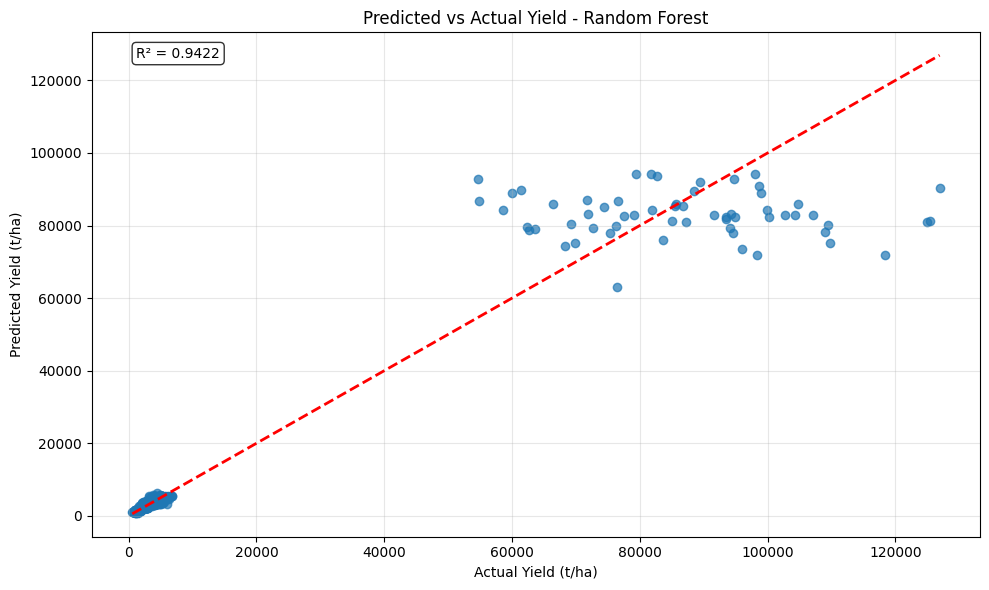

In [13]:
# Create predicted vs actual plot
plt.figure(figsize=(10, 6))

# Get predictions from best model
y_pred_best = best_model.predict(X_test)

plt.scatter(y_test, y_pred_best, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Yield (t/ha)')
plt.ylabel('Predicted Yield (t/ha)')
plt.title(f'Predicted vs Actual Yield - {best_model_name}')
plt.grid(True, alpha=0.3)

# Add R² score to plot
r2_score_val = r2_score(y_test, y_pred_best)
plt.text(0.05, 0.95, f'R² = {r2_score_val:.4f}', transform=plt.gca().transAxes, 
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()


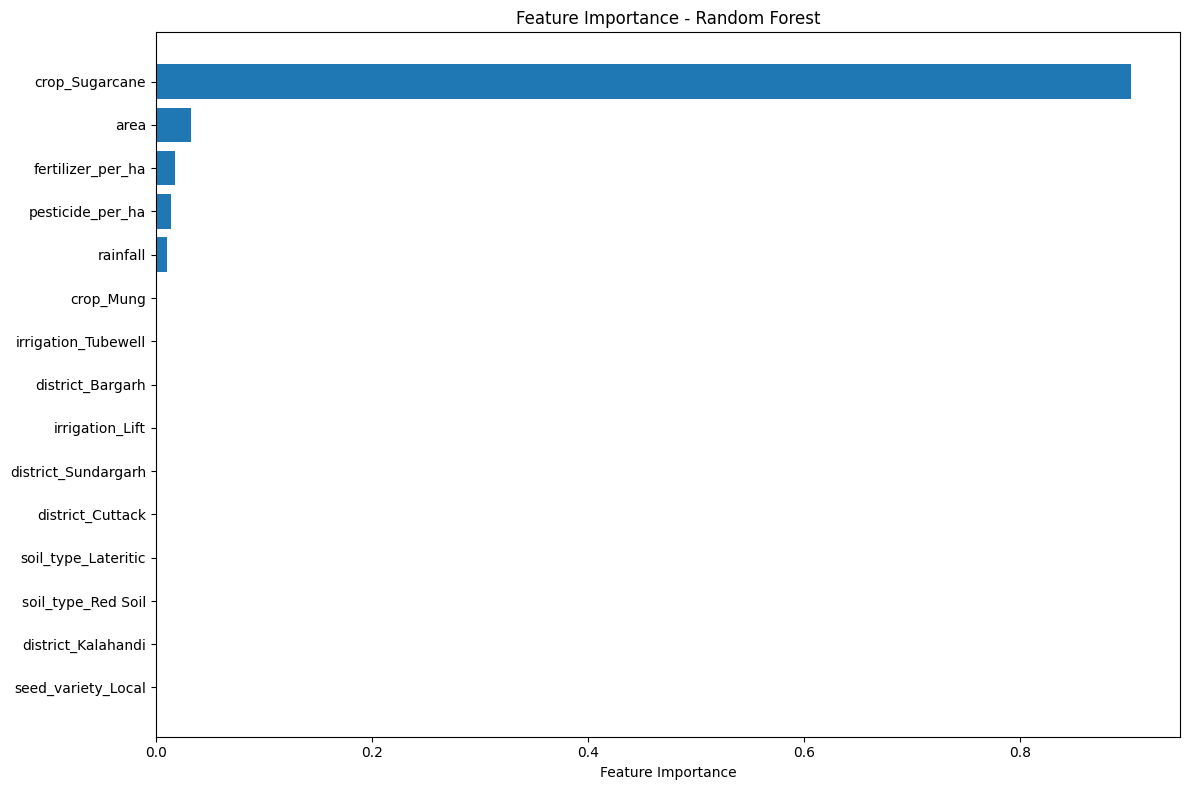

In [15]:
# Feature importance using SHAP (for tree-based models)
if best_model_name == "Random Forest":
    # For Random Forest, use built-in feature importance
    feature_names = numeric_features + list(best_model.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(categorical_features))
    importances = best_model.named_steps['regressor'].feature_importances_
    
    # Create feature importance plot
    plt.figure(figsize=(12, 8))
    indices = np.argsort(importances)[::-1][:15]  # Top 15 features
    
    plt.title('Feature Importance - Random Forest')
    plt.barh(range(len(indices)), importances[indices])
    plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
    plt.xlabel('Feature Importance')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()
    
else:
    # For XGBoost, use SHAP
    try:
        # Get transformed features
        X_transformed = best_model.named_steps['preprocessor'].transform(X_test)
        feature_names = numeric_features + list(best_model.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(categorical_features))
        
        # Create SHAP explainer
        explainer = shap.TreeExplainer(best_model.named_steps['regressor'])
        shap_values = explainer.shap_values(X_transformed)
        
        # Plot SHAP summary
        plt.figure(figsize=(12, 8))
        shap.summary_plot(shap_values, X_transformed, feature_names=feature_names, show=False)
        plt.title('SHAP Feature Importance - XGBoost')
        plt.tight_layout()
        plt.show()
        
    except Exception as e:
        print(f"SHAP plot failed: {e}")
        print("Using built-in feature importance instead...")
        
        # Fallback to built-in importance
        feature_names = numeric_features + list(best_model.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(categorical_features))
        importances = best_model.named_steps['regressor'].feature_importances_
        
        plt.figure(figsize=(12, 8))
        indices = np.argsort(importances)[::-1][:15]
        
        plt.title('Feature Importance - XGBoost')
        plt.barh(range(len(indices)), importances[indices])
        plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
        plt.xlabel('Feature Importance')
        plt.gca().invert_yaxis()
        plt.tight_layout()
        plt.show()


## 5. Save Model and Feature List


In [16]:
# Save the best model
model_path = '../src/ml/models/yield_model.pkl'
joblib.dump(best_model, model_path)
print(f"Model saved to: {model_path}")

# Save feature information
feature_info = {
    'numeric_features': numeric_features,
    'categorical_features': categorical_features,
    'all_features': numeric_features + categorical_features,
    'target_column': 'yield'
}

feature_list_path = '../src/ml/models/feature_list.pkl'
joblib.dump(feature_info, feature_list_path)
print(f"Feature list saved to: {feature_list_path}")

print(f"\nModel training completed successfully!")
print(f"Best model: {best_model_name}")
print(f"Test R² score: {r2_score(y_test, best_model.predict(X_test)):.4f}")


Model saved to: ../src/ml/models/yield_model.pkl
Feature list saved to: ../src/ml/models/feature_list.pkl

Model training completed successfully!
Best model: Random Forest
Test R² score: 0.9422
